# Homework #4 Possible Solutions

This notebook shows one possible set of solutions to Homework #4 by Kevin.  You may have found alternative solutions that are equally valid or more computationally efficient. 

In particular in this notebook you'll notice I do things in a different order than the written assignment.  This is primarily because in doing the assignment in Python, it made sense to me to read in an work on both data fields first, before moving onto computation.  The biggest motivation for this for me was to get both DataArrays for the fields on the same time basis, right from the start.  Your solution may have very well followed the narrative structure of the assignment, however, which is just fine!

## Import packages and set some defaults

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features
from cartopy.util import add_cyclic_point

# initial the pseudorandom number generator
rng = np.random.default_rng()

## Read data from netcdf files and get them on the same time basis

### Retrieve the SST data

We will read in the SST data and modify its time dimension (index) so it has a particular format that we will match with the format of the geopotential height data later.  To do this, we use Panda's [`.to_datetime`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) and give it the existing time dimension output with only the year and month part.  `.to_datetime` then rewrites the datatime to the SST DataArray in the new simplified format. 

In [2]:
sst= xr.open_dataset("HadISST_sst.nc",mask_and_scale=True)["sst"] # read in the SST dataset and extract sst only as a DataArray
sst["time"] = pd.to_datetime(sst["time"].dt.strftime("%Y-%m")) # ensure that the time dimensions have the same format - is there a better way? 
sst # check the time dimension, which is now year and month then the datetime64 default from there


<xarray.DataArray 'sst' (time: 1840, latitude: 180, longitude: 360)>
[119232000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1870-01-01 1870-02-01 ... 2023-04-01
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

### Retrieve the 500 millibar geopotential height data

We will read in the 500 mb geopotential height (hgt) data and modify its time dimension (index) so it has a particular format that we can match with the format of the SST data we set above.  We also use [`.squeeze`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.squeeze.html) with the `drop="True` option when we read in the level data because there is only a single level (500 millibars) -- this removes that 'singleton' dimension from further consideration

In [3]:
hgt = xr.open_dataset("hgt.500mb.mon.mean.nc",engine="netcdf4",mask_and_scale=True)["hgt"].squeeze(drop="True") # read in the gph dataset and extract the hgt variable only as a DataArray, plus squeeze out the singleton dimension
hgt["time"] = pd.to_datetime(hgt["time"].dt.strftime("%Y-%m")) # ensure that the time dimensions have the same format, kinda awkward - is there a better way? 
hgt # check the time dimension, which is now year and month then the datetime64 default from there, and notice the 'level' dimension was squeezed and dropped


<xarray.DataArray 'hgt' (time: 2160, lat: 181, lon: 360)>
[140745600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1836-01-01 1836-02-01 ... 2015-12-01
Attributes: (12/15)
    long_name:         Monthly Geopotential Height on Pressure Levels
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             m
    GRIB_name:         HGT
    var_desc:          Geopotential height
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si-mo ...
    ...                ...
    standard_name:     geopotential_height
    valid_range:       [-1500. 60000.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ -307.88  50208.145]

### Align datasets to same time span

Using `pd.to_datetime` above, we simplified the datetime64-type time dimension that each field had so that they were comparable - the year and the date were already comparable, but each data source used slightly different ways of specifying the day (e.g is the day associated with monthly values the first day of the month? The middle? The 15th? The last day?), hours, minutes, etc. for the monthly data.  If we had tried to find the exact matching times in each dataset, Python would have seen dates with the same month and year but different days or hours as not on the same time basis, and been unable to align our two datasets.  Now with consistent formatting, the time dimension of both our SST and our 500mb height data are the same. (Note: you would think there would be a simpler way to do this -- e.g. set the tolerance of the comparison to only look at year and month and ignore the rest of the datetime string, but I wasn't able to find it -- let me know if you do!)

We now use [`xr.align` with our two datasets to put them on the same time axis](https://docs.xarray.dev/en/stable/generated/xarray.align.html).  The data for the 20th Century Reanalysis data starts earlier (in the 19th century actually) and ends earlier in 2015, compared to the SST data, so we want to have both datasets span from the earliest year of the SST to the most recent year of the 500mb data.  The use of `join="inner"` does an intersect operation, retaining both DataArrays only on their common time span. 

In [4]:
print(sst.shape, hgt.shape) # different time dimension sizes

# use align to get the common time dimensions and reassign the 'clipped' fields to the original DataArray variables
hgt, sst = xr.align(hgt,sst,join="inner") # hgt and sst now have the same time dimension!

print(sst.shape, hgt.shape) # same time dimension size now! 

print(np.min(hgt.time)) # January 1870
print(np.max(sst.time)) # December 2015


(1840, 180, 360) (2160, 181, 360)
(1752, 180, 360) (1752, 181, 360)
<xarray.DataArray 'time' ()>
array('1870-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array('2015-12-01T00:00:00.000000000', dtype='datetime64[ns]')


### EOF analysis of the winter SST data

Drawing on your previous code as well as any lessons learned in the interim or improvements in your programming approach, calculate and map the leading modes of variability of winter Pacific SSTs for the same domain as Deser and Blackmon (1995). This time we calculate all the mode though using  `np.linalg.svd` applied to the centered data matrix. 

In [5]:
# turn negative SST values in NaN
sst = sst.where(sst >= 0, np.nan)

# change the longitudes from -180,180 to 0,360
sst = sst.assign_coords(longitude=(sst.longitude % 360))

# now, sort the coordinates and associated data so they are in the correct order from 0 to 360
sst = sst.sortby(sst.longitude)

# latitude bounds
min_lat = -20.0
max_lat = 60.00

# longitude bounds
min_lon = 120
max_lon = 260

# select a slice and overwrite sst with the output and then take a look
sst = sst.sel(longitude=slice(min_lon,max_lon),latitude=slice(max_lat,min_lat))

# extract coordinates from the DataArray
lat = sst.latitude
lon = sst.longitude

# Sanity check 
# sst.mean(dim="time").plot()

# Calculate the 5-month rolling mean, skipping NaN values
season_length = 5
end_month = 3

sst_ = sst.rolling(time=season_length).mean(skipna=True)
sst_winter = sst_[sst_.time.dt.month == end_month]
sst_winter = sst_winter.drop_isel(time=0)

# get the values from the winter DataArray - at this point they are still 3-dimensional
sst2d = sst_winter.values

# record their original dimensions before we reshape
ntime_sst, nrow_sst, ncol_sst = sst2d.shape

# now reshape, we want rows of the time variable and columns of location - we use 'order=F' because this gives us the correct reshaping
sst2d = np.reshape(sst2d, (ntime_sst, nrow_sst * ncol_sst), order='F')

# here we say 'tell me where there is NOT even a single NaN in the column.  Returns an array with the size of the columns of sst2d
noMissing = ~np.isnan(sst2d).any(axis=0)

# create a new array with only the columns of sst2d that are not missing any data 
sst2dcomplete = sst2d[:, noMissing]

# calculate the anomalies from the long-term seasonal mean for each column
sst_anomalies = sst2dcomplete - sst2dcomplete.mean(axis=0)

# Run the SVD on the centered data matrix
Ut, St, Vt = np.linalg.svd(sst_anomalies,full_matrices=False) 

St = (St**2)/(len(St)-1)
st_var_exp = 100 * (St/np.sum(St))

# get the time series now
pcs = sst_anomalies @ Vt.T

# scale the PCs?
pcs = pcs/np.sqrt(St)

## that the eigenvectors in U and put them into an array for plotting
# create an empty matrix full of NaNs with the same number of columns as the original 2-dimensional data and 2 columns
eof = np.full((nrow_sst*ncol_sst,ntime_sst),np.nan) 
eof[noMissing,:] = Vt.T # take the eigenvalue and put them back in the right place in the eof array 
eof = eof.reshape([nrow_sst,ncol_sst,ntime_sst], order='F') # reshape back to the original dimensions of latitude and longitude plus the eof dimension


### Perform a Rule N test of significance using Gaussian random noise 



In [6]:
# how many iterations?
iterations = 10 # about 4 second per 10 iterations, 34 seconds for 100

# create an array full of NaN values to acccept the random eigenvalues
St_simulated = np.full((iterations,len(St)),np.nan)

# loop over and create the random matrix conditioned on the real data
for i in range(iterations):
    xt = rng.normal(sst_anomalies.mean(axis=0),sst_anomalies.std(axis=0,ddof=1),sst_anomalies.shape)
    xt = xt - xt.mean(axis=0) # probably not necessary, but just for completeness
    Utx,Stx,Vtx = np.linalg.svd(xt,full_matrices=False)
    Stx = (Stx**2)/(len(Stx)-1) # convert singular values to eigenvalues
    St_simulated[i,:] = Stx
    
St_simulated_var = 100 * (St_simulated/np.sum(St_simulated,axis=1)[:,None])

ci95t = np.percentile(St_simulated,95,axis=0)
ci95vart = np.percentile(St_simulated_var,95,axis=0)


Make a stem plot to visualize the eigenvalues and the significance test:

(0.0, 25.0)

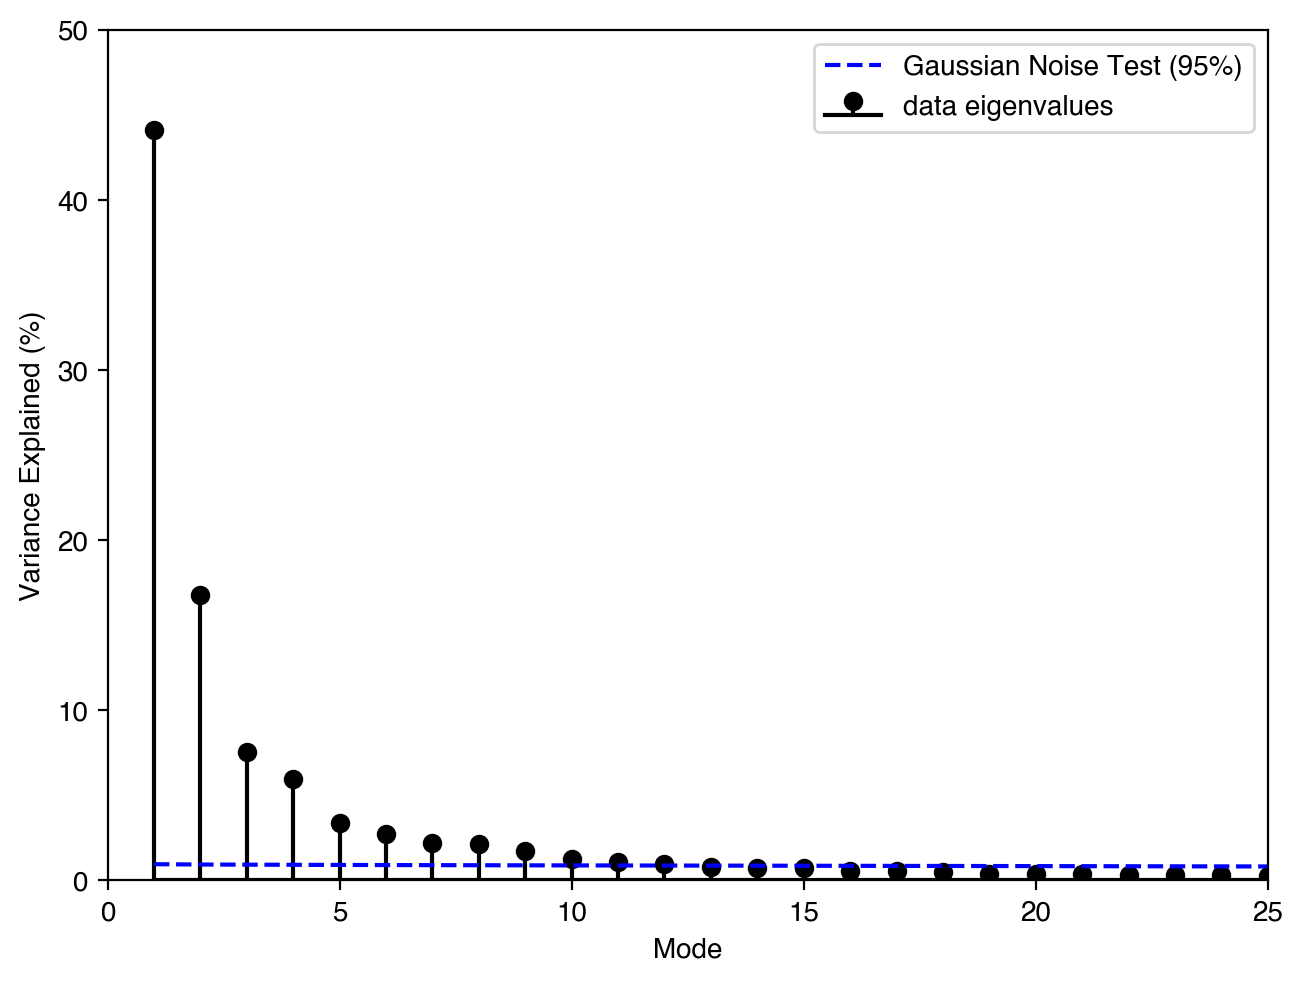

In [7]:
# make the figure
fig, (ax1) = plt.subplots(nrows=1,ncols=1,layout="constrained")

ax1.stem(np.arange(1,len(St)+1),st_var_exp,basefmt="k",markerfmt='ko',linefmt='k-',label='data eigenvalues')
ax1.plot(np.arange(1,len(St)+1),ci95vart,linestyle="--",color="blue",label='Gaussian Noise Test (95%)')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_xlabel('Mode')
ax1.legend()
ax1.set_ylim([0,50])

ax1.set_xlim((0,25))

### Now, perform a Rule N test of significance using ‘red’ autocorrelated noise.

In [8]:
# how many rows and columns of data will we simulate?
nrows, ncols = sst_anomalies.shape 

# what is the mean of each column?
mu = np.mean(sst_anomalies,axis=0)

# what is the standard deviation of the data?
sigma = np.std(sst_anomalies,axis=0,ddof=1)

# determine a phi value to use
acf1 = pd.DataFrame(sst_anomalies).apply(lambda x: x.autocorr())

# how many iterations will we do? 
iterations = 10 # about 5 seconds for 10, 40 seconds for 1000

# create the empty matrix to hold the simulated red noise eigenvalues
ars_simulated = np.full((iterations,len(St)),np.nan)
vars_simulated = np.full((iterations,len(St)),np.nan)

 # mean value and the variance of the random distribution
c = mu # we should have a zero-mean process
sigma_e = np.sqrt((1 - acf1 ** 2))  # sets the appropriate standard deviation to get close to the desired lag-1 autocorrelation

# loop through the j iterations with an inner loop through the i rows of the simulated red noise matrix
for j in range(iterations):
    # create an empty matrix to accept the red noise null simulation
    arnull = np.full(sst_anomalies.shape, np.nan) 

    # set the first value in the array as a random draw with the correct mean and variance
    arnull[0,:] = np.array([c + rng.normal(0, sigma_e, size=ncols)])

    # inner loop i that goes row-by-row to generate the red noise simulation
    for i in range(1, nrows):
        arnull[i,:] = np.array([c + (acf1 * arnull[i-1,:]) + rng.normal(0, sigma_e,size=ncols)])
    
    arnull = (sp.stats.zscore(arnull,axis=0,ddof=1) * np.std(sst_anomalies,axis=0,ddof=1)) # ensure correct mean and standard deviation
        
    # calculate the covariance and then use svd to get the eigenvalues and eigenvectors
    Ux,Sx,Vx = np.linalg.svd(arnull,full_matrices=False) # factor the covariance matrix into eigenvalues and eigenvectors
    Sx = (Sx**2)/(len(Sx)-1) # convert singular values to eigenvalues
    ars_simulated[j,:] = Sx # save the simulated eigenvalues here so we can use them outside the loop
    vars_simulated[j,:] = 100 * (Sx/np.sum(Sx))


In [9]:
# calculate various percentiles from the simulated red noise eigenvalues    
ci99ar = np.percentile(vars_simulated,99,axis=0) # e.g. 99th percentile confidence level
ci95ar = np.percentile(vars_simulated,95,axis=0) # e.g. 95th percentile confidence level
ci90ar = np.percentile(vars_simulated,90,axis=0) # e.g. 90th percentile confidence level

### Sanity Check

Let's make sure we're still getting the answer we got in the previous homework! 

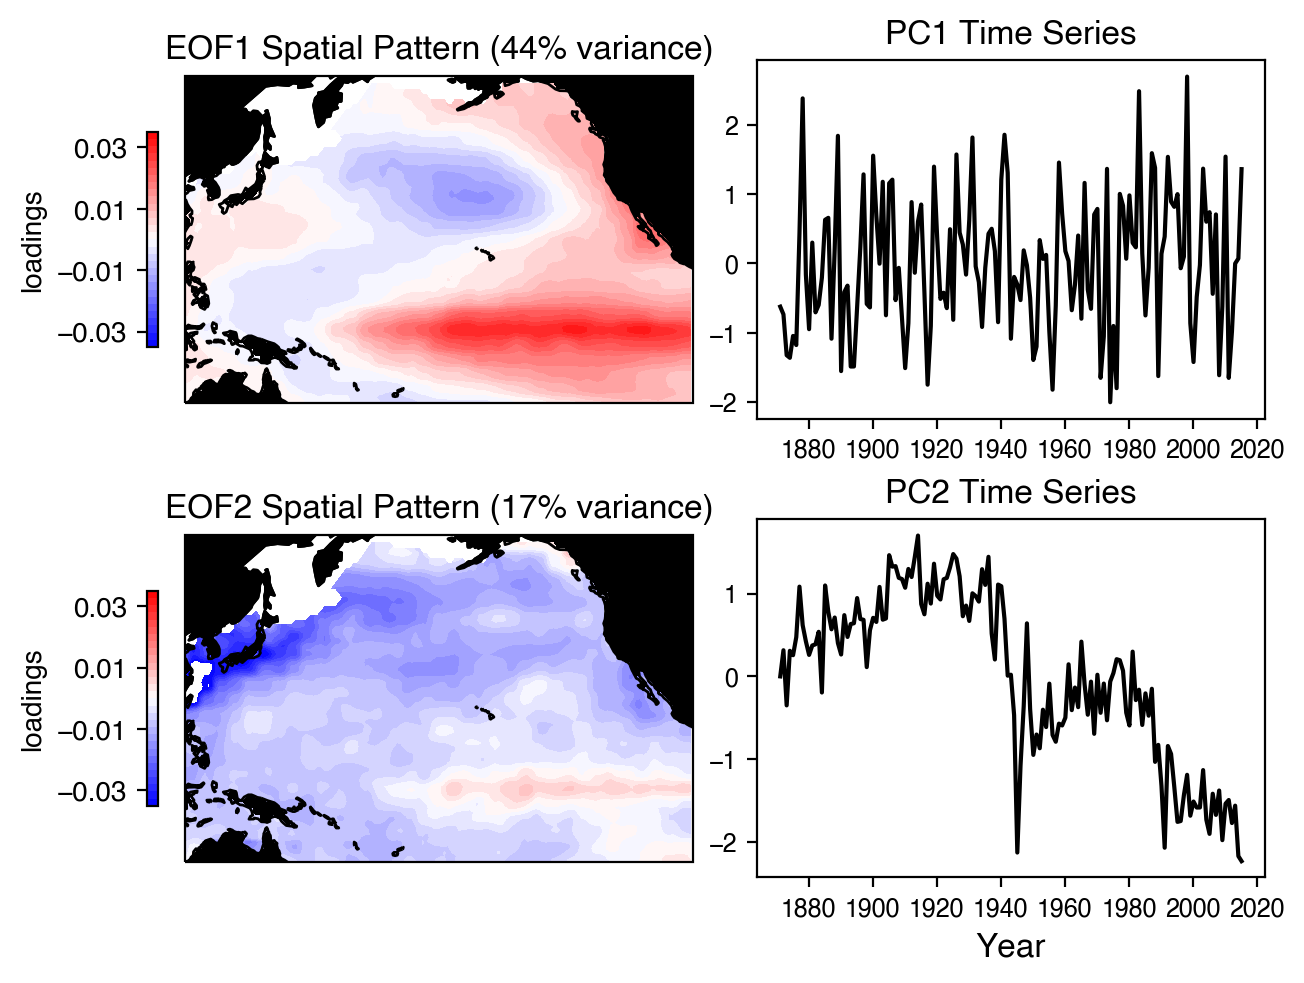

In [10]:
fig=plt.figure(layout="constrained")
gs = fig.add_gridspec(2, 2) # 2 row and 3 column spaces
gs.update(wspace=-1, hspace=-0)

projection=ccrs.Miller(central_longitude=260)# centered on North America

# specifying the levels gives us more control on the map
levels = np.linspace(-0.035, 0.035, 31)

ax1 = fig.add_subplot(gs[0, 0], projection=projection) # map plot in 1st column of grid
fx1 = ax1.contourf(lon,lat,eof[:,:,0],levels=levels, cmap='bwr',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('EOF1 Spatial Pattern ('+str(round(st_var_exp[0]))+'% variance)', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='vertical',location='left',shrink=0.6,ticks=[-0.03, -0.01, 0.01, 0.03])
cb1.set_label('loadings', fontsize=10) 

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sst_winter.time,pcs[:,0],color="black")
ax2.set_title('PC1 Time Series', fontsize=12)
ax2.tick_params(axis="x",labelsize=9)
ax2.tick_params(axis="y",labelsize=9)

ax3 = fig.add_subplot(gs[1, 0], projection=projection) # map plot in 1st column of grid
fx3 = ax3.contourf(lon,lat,-eof[:,:,1],levels=levels, cmap='bwr',add_colorbar=False, transform=ccrs.PlateCarree())
ax3.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax3.coastlines(color="black")  # we can pass arguments to .coastlines function
ax3.add_feature(cfeature.LAND, color='black')
ax3.set_title('EOF2 Spatial Pattern ('+str(round(st_var_exp[1]))+'% variance)', fontsize=12)
cb3 = plt.colorbar(fx3, orientation='vertical',location='left',shrink=0.6,ticks=[-0.03, -0.01, 0.01, 0.03])
cb3.set_label('loadings', fontsize=10) 

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(sst_winter.time,-pcs[:,1],color="black")
ax4.set_xlabel('Year',fontsize=12)
ax4.set_title('PC2 Time Series', fontsize=12)
ax4.tick_params(axis="x",labelsize=9)
ax4.tick_params(axis="y",labelsize=9)

### Field correlations

We'll use `xarray` for the field correlation.  We make a DataArray from the PCs with dimensions of time and mode number.  We then can pass this DataArray to `xr.corr` and let xarray do the work:

In [11]:
# make out PCs into array DataArrays so we can use xarray's correlation methods - see here: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html
pc_array = xr.DataArray(pcs, coords={'time': sst_winter.time, 'mode': np.arange(0,145)}, dims=["time","mode"])

# now do the field correlation between the DataArray with PCs and the seasonal winter SST data
fieldCorrelation = xr.corr(pc_array, sst_winter, dim="time")
fieldCorrelation.coords # you'll see that the output is a DataArray with coordinates of mode #, latitude, and longitude


Coordinates:
  * mode       (mode) int64 0 1 2 3 4 5 6 7 ... 137 138 139 140 141 142 143 144
  * latitude   (latitude) float32 59.5 58.5 57.5 56.5 ... -17.5 -18.5 -19.5
  * longitude  (longitude) float32 120.5 121.5 122.5 123.5 ... 257.5 258.5 259.5

Let's now plot the field correlations:

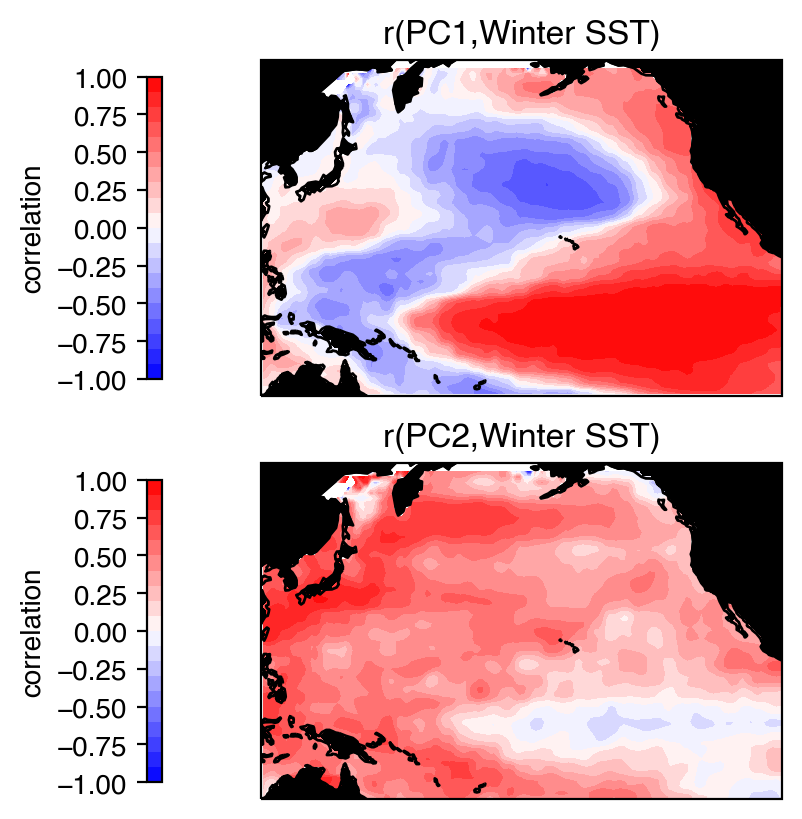

In [12]:
# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Miller(central_longitude=260)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 21)

fx1 = ax1.contourf(lon,lat,fieldCorrelation[0,:,:],levels=levels, cmap='bwr',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(PC1,Winter SST)', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='vertical',location='left',shrink=0.9,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('correlation', fontsize=10) 

fx2 = ax2.contourf(lon,lat,fieldCorrelation[1,:,:],levels=levels, cmap='bwr',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('r(PC2,Winter SST)', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('correlation', fontsize=10) 

Just for fun, let's do a contour line (unfilled) plot, more like what is in the Deser and Blackmon paper - I'm going to add some contour labels (in the absence of filled color contours) and give them a bit of a gray background to make them pop a bit more.

Text(0.5, 1.0, 'r(PC2,Winter SST)')

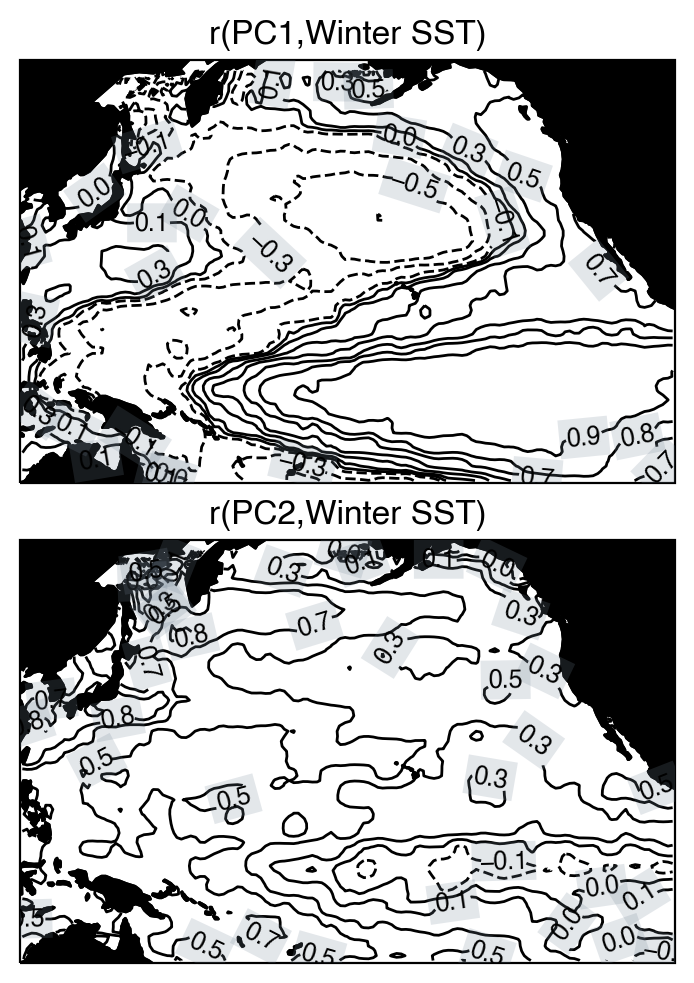

In [13]:
# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,layout='constrained',subplot_kw={'projection': ccrs.Miller(central_longitude=260)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 11)
levels = [-0.9, -0.8, -0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9]


# Mode 1
lx1 = ax1.contour(lon,lat,fieldCorrelation[0,:,:],levels=levels,colors='k',linewidths=1,transform=ccrs.PlateCarree())
cx1 = ax1.clabel(lx1, fontsize=9, inline=True)
myboxstyle = dict(boxstyle="square", edgecolor="none", facecolor="lightslategray", alpha=0.2) # see here https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html
plt.setp(cx1, bbox=myboxstyle) # sets the property (setp) of the axes given - see here https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.setp.html
ax1.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.add_feature(cfeature.LAND, color='black')
ax1.set_title('r(PC1,Winter SST)', fontsize=12)

# Mode 2
lx2 = ax2.contour(lon,lat,fieldCorrelation[1,:,:],levels=levels,colors='k',linewidths=1,transform=ccrs.PlateCarree())
cx2 = ax2.clabel(lx2, fontsize=9, inline=True)
myboxstyle = dict(boxstyle="square", edgecolor="none", facecolor="lightslategray", alpha=0.2)
plt.setp(cx2, bbox=myboxstyle) # sets the property (setp) of the axes given
ax2.set_extent([120, 260, -20, 61],crs=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.add_feature(cfeature.LAND, color='black')
ax2.set_title('r(PC2,Winter SST)', fontsize=12)


### Compositing on extreme years

We will now use the PC1 time series to select a set of years that correspond to extremes of the time series (which themselves correspond to El Nino and La Nina yeaers).  Using those years, we'll make a composite mean of the geopotential height to look at atmospheric circulation anomalies during extreme ENSO behavior.  

First, we'll set some thresholds for selecting extreme years, based on quantiles of PC1.  We then go into our array of PCs, and for PC1 we use `.where` to identify only those times when the value of PC1 is above or below those thresholds.  Be sure to then take a look at what the result of this looks like!  It is a new DataArray with NaN values for the years that do NOT meet this threshold, but the values for those years that do are still there.  Note that this isn't a Boolean array, which would be another way to approach this:

In [14]:
upperThreshold = pc_array[:,0].quantile(0.90)
lowerThreshold = pc_array[:,0].quantile(0.10)

elNino = pc_array[:,0].where(pc_array[:,0]>=upperThreshold)
laNina = pc_array[:,0].where(pc_array[:,0]<=lowerThreshold)
elNino

<xarray.DataArray (time: 145)>
array([      nan,       nan,       nan,       nan,       nan,       nan,
             nan, 2.3818374,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
       1.8412803,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan, 1.5548099,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
       1.3965942,       nan,       nan,       nan,       nan,       nan,
             nan, 1.5721289,       nan,       nan,       nan,       nan,
       1.817313 ,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 1.8566942,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan, 1.4555186,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan, 2.4855971,       nan,
             nan,       nan, 1.5906873, 1.379207 ,       nan,       nan,
             nan, 1.5379022,       nan,       nan,       nan,       nan,
             nan, 2.6959374,       nan,       nan,       nan,       nan,
       1.3676409,       nan,       nan,       nan,       nan,       nan,
             nan, 1.5411297,       nan,       nan,       nan,       nan,
             nan], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1871-03-01 1872-03-01 ... 2015-03-01
    mode      int64 0
    quantile  float64 0.9

Just a fun plot to look at the PC1 time series and the selected extremes:

Text(1868-01-01 00:00:00, 2.5, 'text')

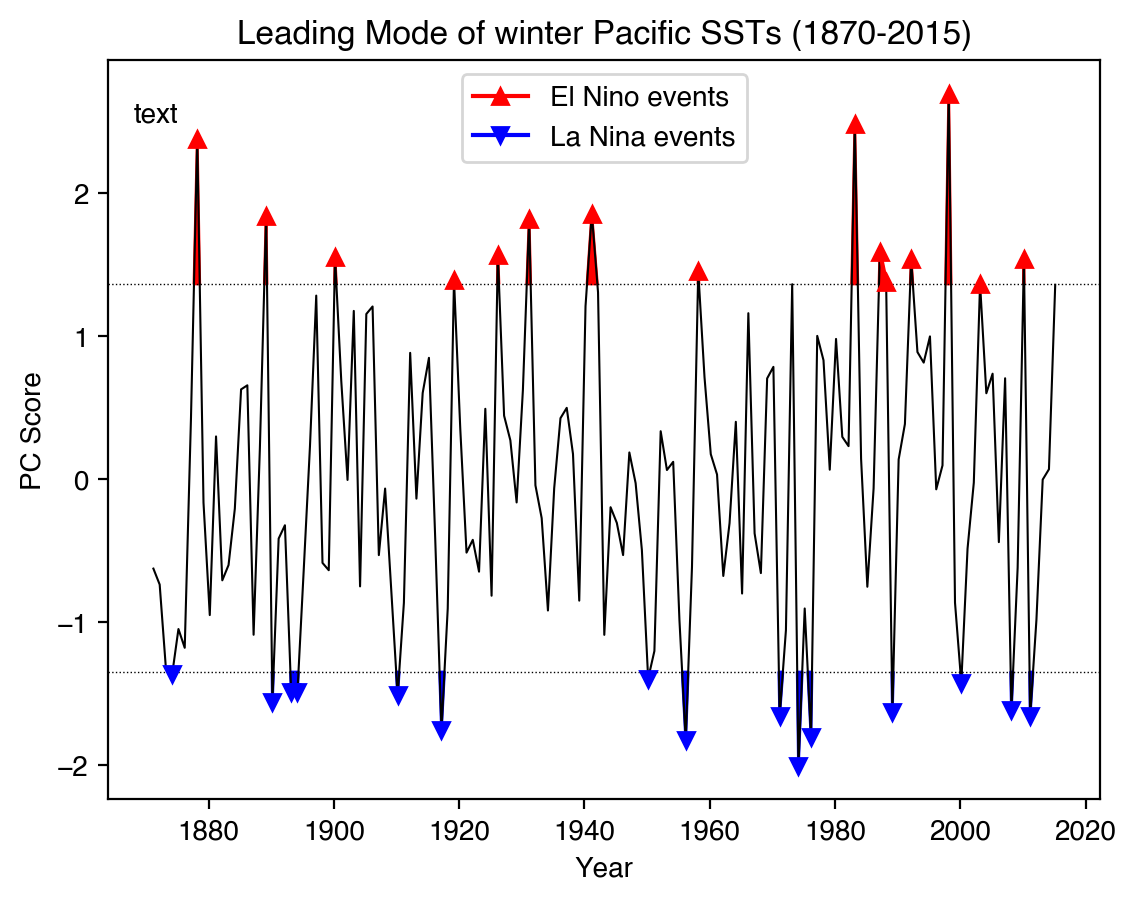

In [15]:
# quick figure to visual what we're looking at here
plt.plot(pc_array['time'],pc_array[:,0],'k',linewidth=0.75)
plt.fill_between(pc_array['time'],upperThreshold,pc_array[:,0],where=(pc_array[:,0]>=upperThreshold),color='red',interpolate=True)
plt.fill_between(pc_array['time'],pc_array[:,0],lowerThreshold,where=(pc_array[:,0]<=lowerThreshold),color='blue',interpolate=True)
plt.axhline(upperThreshold,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(lowerThreshold,color='black',linewidth=0.5,linestyle='dotted')
plt.plot(elNino["time"],elNino,color="red",marker="^",label='El Nino events')
plt.plot(laNina["time"],laNina,color="blue",marker="v",label='La Nina events')

plt.xlabel('Year')
plt.ylabel('PC Score')
plt.title('Leading Mode of winter Pacific SSTs (1870-2015)')
plt.legend()

plt.text(pd.to_datetime("1868"),2.5,'text') # why .to_datetime?  Because the x-axis is from an xarray datetime64 type which is stored as nanoseconds, so need to convert


Process the geopotential height data to get ready to make the winter spatial composites and do a sanity check:

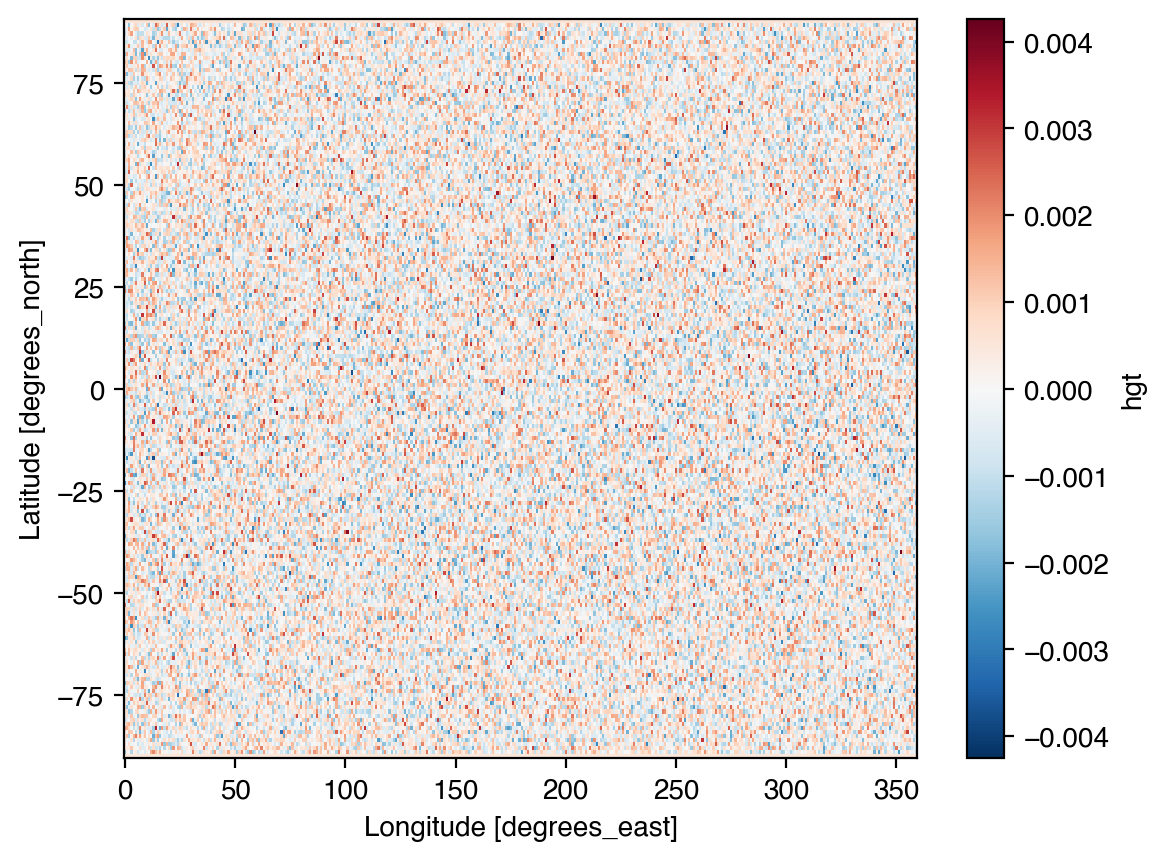

In [16]:
hgt_ = hgt.rolling(time=season_length).mean(skipna=True)
hgt_winter = hgt_[hgt_.time.dt.month == end_month]
hgt_winter = hgt_winter.drop_isel(time=0)

hgt_winter = hgt_winter - hgt_winter.mean(dim="time")

# sanity check - if this worked, mean everywhere should be close-ish to zero and appear random
hgt_winter.mean(dim="time").plot()

Use the DataArrays we created above from the PC1 and the extreme years to select just the years associated with the PC1 extremes in the height data, drop any NaN values (e.g. so, the non-extreme years that had NaNs for `elNino` and 'laNina` get dropped from the composite calculation!) and then take the time mean of the non-dropped years in the height field.  Then plot the composite mean height fields that result from this calculation. Note that this is definitely NOT the only way to do this!  You may have found a better or more intuitive way, which is great!

Text(0.5, 1.0, 'Negative SST Mode (La Nina)')

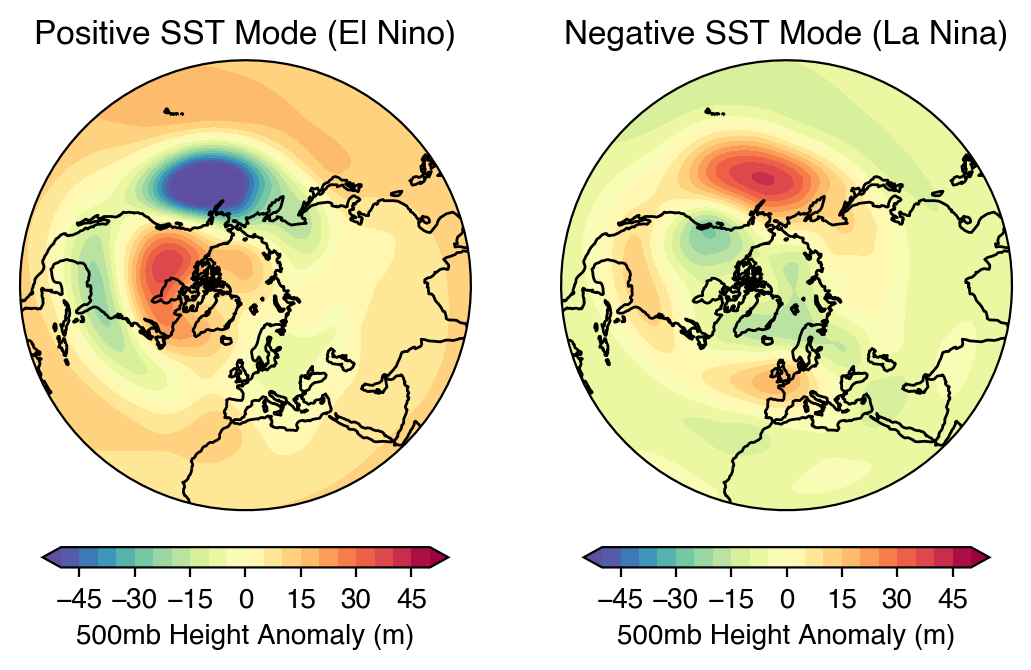

In [17]:
pos_hgt = hgt_winter.sel(time=elNino.dropna(dim='time')['time']).mean(dim='time')
neg_hgt = hgt_winter.sel(time=laNina.dropna(dim='time')['time']).mean(dim='time')

# extract coordinates from the DataArray
hgt_lat = hgt.lat
hgt_lon = hgt.lon

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, subplot_kw={'projection': ccrs.NorthPolarStereo()})

levs=np.arange(-50,50.1,5)

# this let's matplotlib and cartopy know to 'wrap' at the 360 to 0 longitude transition
pos_hgt,hgt_lonc=add_cyclic_point(pos_hgt,coord=hgt_lon)
neg_hgt,hgt_lonc = add_cyclic_point(neg_hgt,coord=hgt_lon)

cs1=ax1.contourf(hgt_lonc,hgt_lat,pos_hgt,levels=levs,transform = ccrs.PlateCarree(),extend='both',cmap="Spectral_r")
ax1.set_extent([0, 360, 10, 90], crs=ccrs.PlateCarree())
cb1 = plt.colorbar(cs1, orientation='horizontal',location='bottom',shrink=0.9,pad=0.05)
cb1.set_label('500mb Height Anomaly (m)')
ax1.coastlines()
# force to remain circular despite latitude limits - from https://scitools.org.uk/cartopy/docs/v0.15/examples/always_circular_stereo.html
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.set_title('Positive SST Mode (El Nino)')

cs2=ax2.contourf(hgt_lonc,hgt_lat,neg_hgt,levels=levs,transform = ccrs.PlateCarree(),extend='both',cmap="Spectral_r")
ax2.set_extent([0, 360, 10, 90], crs=ccrs.PlateCarree())
cb2 = plt.colorbar(cs2, orientation='horizontal',location='bottom',shrink=0.9,pad=0.05)
cb2.set_label('500mb Height Anomaly (m)')
ax2.coastlines()
# force to remain circular despite latitude limits - from https://scitools.org.uk/cartopy/docs/v0.15/examples/always_circular_stereo.html
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.set_title('Negative SST Mode (La Nina)')